# Regressão Não Paramétrica (Nonparametric Regression)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

* Introdução
* Regressão Polinomial e Funções Degrau
  * Regressão Polinomial
  * Regressão com Funções Degrau (Step Functions)

### Referências

* Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly Media, 2019.
* Athey, S., & Imbens, G. (2017). "The State of Applied Econometrics: Causality and Policy Evaluation." *Journal of Economic Perspectives*.
* Mullainathan, S., & Spiess, J. (2017). "Machine Learning: An Applied Econometric Approach." *Journal of Economic Perspectives*.
* Varian, H. R. (2014). "Big Data: New Tricks for Econometrics." *Journal of Economic Perspectives*.

### 1. Introdução

Nesta aula, exploraremos as técnicas de **regressão não paramétrica**, com foco em métodos que não impõem uma forma funcional específica para a relação entre as variáveis independentes e a variável dependente. Esse tipo de abordagem é particularmente útil em situações em que essa relação é **complexa ou desconhecida**.

Uma ***relação complexa*** refere-se a situações em que os efeitos das variáveis explicativas sobre a variável de interesse **não podem ser capturados adequadamente por funções lineares ou polinomiais de baixa ordem**. Isso pode ocorrer, por exemplo, quando há mudanças bruscas de inclinação, efeitos em diferentes escalas ou interações não lineares entre os regressores.

Nesse contexto, os modelos não paramétricos oferecem maior flexibilidade ao permitir que os dados “falem por si”, evitando a imposição de uma estrutura funcional incorreta que possa induzir a **viés de especificação**.

**Definições Fundamentais**

**Regressão Paramétrica**
Modelos que especificam completamente a forma funcional da relação entre as variáveis, assumindo que os dados seguem uma distribuição parametrizada por um número finito de parâmetros.

- **Exemplos típicos**: Regressão Linear Clássica (OLS); modelos Logit e Probit; modelos ARIMA em séries temporais; regressões exponenciais e log-lineares.
- **Características**:  
  - Forma funcional totalmente especificada (ex.: linear, quadrática).  
  - Estimativa baseada em um número fixo de parâmetros.  
  - Mais eficientes quando bem especificados, mas sensíveis à má especificação da forma funcional.


**Regressão Não Paramétrica**
Modelos que **não impõem uma forma funcional específica** entre as variáveis. Em vez disso, permitem que os dados determinem a forma da relação, geralmente exigindo amostras maiores para obter estimativas confiáveis.

- **Exemplos típicos**: Regressão por Núcleo (Kernel Regression de Nadaraya-Watson); K-Vizinhos Mais Próximos (KNN); Árvores de Decisão, Random Forest, BART; Splines; LOESS.
- **Características**:  
  - Alta flexibilidade, capaz de capturar relações complexas e não lineares.  
  - Alta demanda por dados (problema da *curse of dimensionality*).  
  - Não especificam um número fixo de parâmetros.  
  - Resultados podem ser mais difíceis de interpretar.


**Regressão Semiparamétrica**
Modelos que combinam componentes paramétricos e não paramétricos. Em geral, assumem uma estrutura funcional para parte dos efeitos e deixam o restante livre, a ser estimado de forma não paramétrica.

- **Exemplos típicos**:  
  - Modelo de Cox na análise de sobrevivência.  
  - Double Machine Learning (DML), com uso de algoritmos de aprendizado de máquina para controle de covariáveis.  
  - Modelo de Regressão Parcialmente Linear:

    $$ y_i = X_i' \beta + g(Z_i) + \varepsilon_i $$

  - onde $y_i$ é a variável dependente, $X_i$ é um vetor de variáveis independentes, $\beta$ é um vetor de parâmetros a serem estimados, $g(Z_i)$ é uma função não-paramétrica das variáveis $Z_i$, e $\epsilon_i$ é o erro aleatório.

* ***Características:***
  * Oferecem equilíbrio entre estrutura e flexibilidade.
  * Menos dependentes da correta especificação da forma funcional.
  * Mais interpretáveis que modelos totalmente não paramétricos, e mais robustos que modelos totalmente paramétricos.


Minha ideia é conduzir vocês da relação paramétrica que estamos acostumados, em direção à não paramétrica.

Vamos construir a aula sobre exemplos práticos, e depois discutir as definições.

**Carregando pacotes**

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Carregando Dados**

In [115]:
df = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Wage.csv', index_col=0)
df

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
376816,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
302281,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
10033,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
14375,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


Este conjunto de dados contém informações sobre ***salários e características individuais***.

Nosso principal objetivo será explicar os salários usando os observáveis ​​contidos no conjunto de dados.

### 2. Regressão Polinomial e Funções Degrau (Step Functions)

A ***regressão polinomial*** introduz não linearidades ao modelo linear padrão, substituindo-o por uma função polinomial. As ***funções escalonadas (degrau)*** dividem a faixa de uma variável em "caixas" (bins) e ajustam uma constante diferente em cada uma, evitando impor uma estrutura global.


### 2.1. Regressão Polinomial

Como vimos no OLS, a maneira mais comum de introduzir linearidades é substituir o modelo linear padrão por uma função polinomial:

$$ y = \beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k + \epsilon_{i} $$


***Exemplo em Python***

Voltando a nossa base de dados. Suponha que queremos investigar a relação entre $wage$ e $age$. Vamos primeiro plotar as duas variáveis e entender se há algum comportamento claro entre elas. 


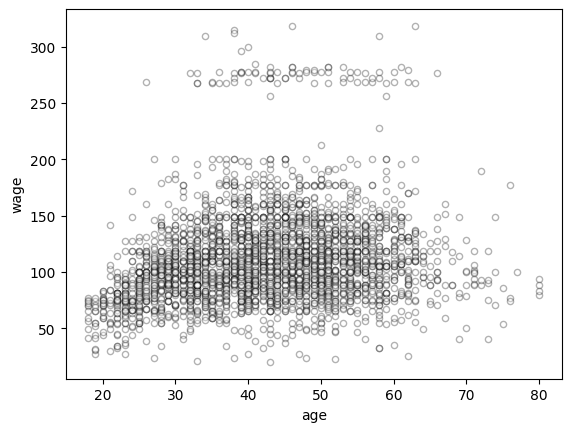

In [116]:
# Scatterplot dos dados
df.plot.scatter('age','wage', color='w', edgecolors='k', alpha=0.3);

Repare que a relação parece ser **complexa** e **não linear**. Ou seja:
* Forma matemática: "A relação parece ser não linear."
* Dificuldade em descrever/modelar: "A relação parece ser complexa."

Chama atenção que parece existir uma separação entre salário acima e abaixo de 250, não?

***Variáveis***

Temos a renda ($y$), a idade ($X$), e vamos criar uma nova variável de resultado indicativa/binária ($y01$) que será "1" se a renda for maior que 250.000 USD, e "0" caso contrário (e adicionar ao datafrane df).

In [117]:
X = df['age']
y = df['wage']
df['y01'] = (df.wage > 250).map({False:0, True:1}).values
y01 = df['y01']

Vamos expandir nossos polinômios de regressão linear de diferentes graus: de 1 a 5.

In [118]:
# importar polynomial features do sklearn
from sklearn.preprocessing import PolynomialFeatures

X_poly1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X_poly2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X_poly3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X_poly4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X_poly5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

***OBS:*** O Scikit-Learn espera que as entradas sejam uma matriz de forma (*n_amostras, n_características*).
Mesmo com apenas uma variável, você precisa informar como (*n_amostras, 1*), e não apenas como (*n_amostras,*).

```python	
 array([[25],
       [30],
       [35],
       [40],
       ...])
```
Por isso, precisamos usar o método `.reshape()` para transformar a variável em uma matriz de duas dimensões. O método `reshape(-1, 1)` transforma a variável em uma matriz com uma coluna e tantas linhas quantas forem necessárias.


Se executarmos uma regressão linear em uma expansão polinomial de 4 graus de $age$, isso é o que parece:

In [119]:
import statsmodels.api as sm

# rodar o OLS no polinomio de grau 4
ols_poly4 = sm.OLS(y, X_poly4).fit()
print(ols_poly4.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                qua, 14 mai 2025   Prob (F-statistic):           2.77e-57
Time:                        17:08:34   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

Você poderia ter feito a análise da forma manual:

In [120]:
# Outra forma de fazer o mesmo processo "forma manual" Versão 2 (v2)
ols_poly4_v2 = sm.OLS.from_formula('wage ~ age + I(age**2) + I(age**3) + I(age**4)', data=df).fit()
print(ols_poly4_v2.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                qua, 14 mai 2025   Prob (F-statistic):           2.77e-57
Time:                        17:08:41   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -184.1542     60.040     -3.067      

OBS: `I(...)` diz ao interpretador de fórmulas: “avalie isso como uma expressão Python comum”

***Medidas de Ajuste***

Agora os coeficientes individuais **não são de particular interesse**. Nosso principal objetivo é **capturar da melhor forma possível a relação entre `age` e `wage`**. Mas como escolher entre diferentes polinômios?

Vamos comparar modelos com diferentes graus polinomiais. Para cada regressão, analisaremos um conjunto de métricas de desempenho.

***Critérios para prever uma variável contínua***

- **MAE (Mean Absolute Error)**  
  $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$  
  Interpretação: quanto **menor**, melhor.

- **MSE (Mean Squared Error)**  
  $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$  
  Interpretação: quanto **menor**, melhor.

- **RMSE (Root Mean Squared Error)**  
  $$RMSE = \sqrt{MSE}$$  
  Interpretação: quanto **menor**, melhor.

- **R² (Coeficiente de Determinação)**  
  $$R^2 = 1 - \frac{SSR}{SST}$$  
  onde $SSR$ é a soma dos quadrados dos resíduos e $SST$ é a soma total dos quadrados.  
  Interpretação: quanto **maior**, melhor.

- **R² ajustado**  
  $$R^2_{\text{ajustado}} = 1 - \left(1 - R^2\right) \frac{n - 1}{n - k - 1}$$  
  onde $k$ é o número de variáveis independentes.  
  Interpretação: quanto **maior**, melhor. O R² ajustado penaliza a adição de variáveis irrelevantes.


***Critérios baseados em erro de predição***

Esses são úteis quando o foco está na **precisão preditiva fora da amostra**:

- **MAPE (Mean Absolute Percentage Error)**  
  $$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$$  
  Interpretação: quanto **menor**, melhor.  
  Obs: sensível quando $y_i$ se aproxima de zero.


***Critérios de complexidade e ajuste penalizado***

Esses critérios penalizam modelos muito complexos, ajudando a evitar **overfitting**:

- **AIC (Akaike Information Criterion)**  
  $$AIC = 2k - 2 \ln(L)$$  
  onde $k$ é o número de parâmetros e $L$ é a verossimilhança do modelo.  
  Interpretação: quanto **menor**, melhor.

- **BIC (Bayesian Information Criterion)**  
  $$BIC = k \ln(n) - 2 \ln(L)$$  
  onde $k$ é o número de parâmetros e $n$ é o número de observações.  
  Interpretação: quanto **menor**, melhor.


Essas métricas ajudam a escolher o grau polinomial que oferece o melhor equilíbrio entre **qualidade de ajuste** e **simplicidade do modelo**, mitigando o risco de **overfitting**.


In [121]:
# Run regressions
fit_1 = sm.OLS(y, X_poly1).fit()
fit_2 = sm.OLS(y, X_poly2).fit()
fit_3 = sm.OLS(y, X_poly3).fit()
fit_4 = sm.OLS(y, X_poly4).fit()
fit_5 = sm.OLS(y, X_poly5).fit()

Rotina para calcular as métricas de ajuste:

In [122]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def print_metrics(y_true, y_pred, X, fit, label):
    n = len(y_true)
    k = X.shape[1] - 1  # subtrai 1 para ignorar o intercepto
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true)))

    # AIC e BIC vindos do statsmodels
    aic = fit.aic
    bic = fit.bic

    print(f'{label}')
    print(f'  MAE        : {mae:.2f}')
    print(f'  MSE        : {mse:.2f}')
    print(f'  RMSE       : {rmse:.2f}')
    print(f'  R²         : {r2:.4f}')
    print(f'  R² ajustado: {r2_adj:.4f}')
    print(f'  MAPE       : {mape:.4f}')
    print(f'  AIC        : {aic:.2f}')
    print(f'  BIC        : {bic:.2f}')
    print()

In [123]:
# Organizar os resultados e matrizes
fits = [fit_1, fit_2, fit_3, fit_4, fit_5]
X_polys = [X_poly1, X_poly2, X_poly3, X_poly4, X_poly5]

# Imprimir as métricas
for i, (fit, X_poly) in enumerate(zip(fits, X_polys), 1):
    print_metrics(y, fit.fittedvalues, X_poly, fit, f'Grau {i}')


Grau 1
  MAE        : 28.77
  MSE        : 1674.07
  RMSE       : 40.92
  R²         : 0.0383
  R² ajustado: 0.0380
  MAPE       : 0.2918
  AIC        : 30786.67
  BIC        : 30798.69

Grau 2
  MAE        : 27.77
  MSE        : 1597.81
  RMSE       : 39.97
  R²         : 0.0821
  R² ajustado: 0.0815
  MAPE       : 0.2788
  AIC        : 30648.80
  BIC        : 30666.82

Grau 3
  MAE        : 27.73
  MSE        : 1592.56
  RMSE       : 39.91
  R²         : 0.0851
  R² ajustado: 0.0842
  MAPE       : 0.2781
  AIC        : 30640.92
  BIC        : 30664.95

Grau 4
  MAE        : 27.70
  MSE        : 1590.53
  RMSE       : 39.88
  R²         : 0.0863
  R² ajustado: 0.0850
  MAPE       : 0.2779
  AIC        : 30639.11
  BIC        : 30669.14

Grau 5
  MAE        : 27.71
  MSE        : 1590.11
  RMSE       : 39.88
  R²         : 0.0865
  R² ajustado: 0.0850
  MAPE       : 0.2780
  AIC        : 30640.30
  BIC        : 30676.34



Melhorias Marginais: Conforme o grau aumenta de 1 para 5:
* As métricas de erro (MAE, MSE, RMSE, MAPE) melhoram levemente.
* R² e R² ajustado também aumentam, indicando melhor explicação da variabilidade.
* Mas os ganhos são cada vez menores, sugerindo retorno decrescente ao aumentar a complexidade.

AIC e BIC:
* O AIC atinge o menor valor no grau 4.
* O BIC, mais penalizador, também é menor no grau 4.

Embora modelos mais complexos consigam representar melhor a amostra, eles nem sempre generalizam melhor. AIC e BIC nos ajudam a identificar quando o ganho de explicação começa a ser superado pelo risco de overfitting. Neste caso, grau 4 representa o melhor equilíbrio entre ajuste e simplicidade.


Isso indica que grau 4 parece ser o ponto ótimo, balanceando ajuste e complexidade.

In [124]:
# Set polynomial X to 4th degree
X_poly = X_poly4

### 2.1.1. Regressões da Família Binomial

Uma regressão da **família binomial** é um tipo de modelo estatístico pertencente à classe dos **Modelos Lineares Generalizados (GLMs)**, adequado quando a ***variável dependente é binária*** (ou seja, assume dois valores, como 0 e 1). O nome "binomial" se refere ao fato de que a variável resposta segue uma **distribuição binomial condicionalmente às covariáveis**.


***Características Gerais***

- **Distribuição da família exponencial**: Binomial  
- **Variável resposta**:
  - Binária (ex: sucesso/fracasso, 1/0)
  - Ou proporção (ex: número de sucessos em $n$ tentativas)
- **Função de ligação** (*link function*): diversas, como `logit`, `probit`, `cloglog`, `identity`, etc.
- **Objetivo**: modelar a probabilidade de sucesso $ \Pr(Y = 1 \mid X) $ como uma função das covariáveis $X$


***Forma Geral do Modelo***

Ao contrário da regressão linear clássica, os GLMs utilizam uma função de ligação $ g(\cdot) $ para conectar a média da variável resposta ao preditor linear:

$$
g\left( \mathbb{E}[Y_i \mid X_i] \right) = \beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k
$$

No caso da regressão logística (link `logit`), essa função de ligação é a **Probabilidade Logística**.


### 2.1.2. Funções de Ligação para a Família Binomial

A escolha da função de ligação determina como a regressão transforma a média condicional para ser modelada como uma combinação linear dos regressores. Algumas funções de ligação comuns para a família binomial são:


In [125]:
# List link functions for the Binomial family
sm.families.family.Binomial.links

[statsmodels.genmod.families.links.Logit,
 statsmodels.genmod.families.links.probit,
 statsmodels.genmod.families.links.cauchy,
 statsmodels.genmod.families.links.Log,
 statsmodels.genmod.families.links.CLogLog,
 statsmodels.genmod.families.links.LogLog,
 statsmodels.genmod.families.links.identity]

### 2.1.3. Regressão Logística (link logit)

A função `logit` assume que o termo de erro segue uma distribuição Valor Extremo Tipo I (ou Gumbel). Nesse caso, a probabilidade condicional de sucesso é modelada por:

$$

Pr(Y=1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k)}} = \frac{e^{(\beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k)}}{1 + e^{(\beta_0 + \beta_1 x_{i} + \beta_2 x_{i}^2 + \ldots + \beta_k x_{i}^k)}}

$$


Se ao invés disso assumíssemos que os erros seguem uma distribuição normal padrão, obteríamos a regressão probit.

In [126]:
# Configurar o link logit para GLM com família binomial
logit_link = sm.families.Binomial(sm.genmod.families.links.logit())

# Estimar o modelo (ex: y01 como binária, X_poly como polinômios de age)
logit_poly = sm.GLM(y01, X_poly, family=logit_link).fit()

# Exibir os coeficientes
print(logit_poly.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    y01   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                qua, 14 mai 2025   Deviance:                       701.22
Time:                        17:09:16   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

Ou seja:
* $const = -109.5530$
* $x1    =   8.9950$
* $x2    =  -0.2816$
* $x3    =   0.0039$
* $x4    =  -1.949e-05$

logo, a equação da regressão logística seria:
$$
Pr(Y=1 \mid X) = \frac{e^{-109.5530 + 8.9950 x_{i} - 0.2816 x_{i}^2 + 0.0039 x_{i}^3 - 1.949e-05 x_{i}^4}}{1 + e^{-109.5530 + 8.9950 x_{i} - 0.2816 x_{i}^2 + 0.0039 x_{i}^3 - 1.949e-05 x_{i}^4}}
$$


depois plotaremos. Lembre que a relação não é linear, e sim logit.

***Comparação de Modelos Lineares***

Qual é a diferença com o modelo linear?

In [127]:
# Run OLS regression with binary outcome
ols_poly = sm.OLS(y01, X_poly).fit()
print(ols_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                    y01   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.158
Date:                qua, 14 mai 2025   Prob (F-statistic):            0.00232
Time:                        17:09:25   Log-Likelihood:                 1246.9
No. Observations:                3000   AIC:                            -2484.
Df Residuals:                    2995   BIC:                            -2454.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1126      0.240     -0.468      0.6

A magnitude dos coeficientes é diferente, mas os sinais são os mesmos.

***Dados de plotagem e previsões***

Vamos traçar as curvas estimadas em relação à distribuição de dados.

In [128]:
# Generate predictions
x_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
X_poly_test = PolynomialFeatures(4).fit_transform(x_grid)
y_hat1 = sm.OLS(y, X_poly).fit().predict(X_poly_test)
y01_hat1 = logit_poly.predict(X_poly_test)

In [129]:
# Ploimport matplotlib.pyplot as plt

def plot_predictions(X, y, x_grid, y_hat1, y01_hat1, title=''):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # OLS plot
    ax[0].scatter(X, y, color='w', edgecolor='k', alpha=0.3)
    ax[0].plot(x_grid, y_hat1, color='blue', label='OLS Prediction')
    ax[0].set_title(title + ' - OLS')
    ax[0].set_xlabel('Age')
    ax[0].set_ylabel('Wage')
    ax[0].legend()

    # Logistic plot
    ax[1].scatter(X, (y > 250).astype(int), color='w', edgecolor='k', alpha=0.3)
    ax[1].plot(x_grid, y01_hat1, color='red', label='Logistic Prediction')
    ax[1].set_title(title + ' - Logistic')
    ax[1].set_xlabel('Age')
    ax[1].set_ylabel('Pr(Wage > 250)')
    ax[1].set_ylim(0, 0.2)  # <== ajuste da escala do eixo y
    ax[1].legend()

    plt.tight_layout()
    plt.show()

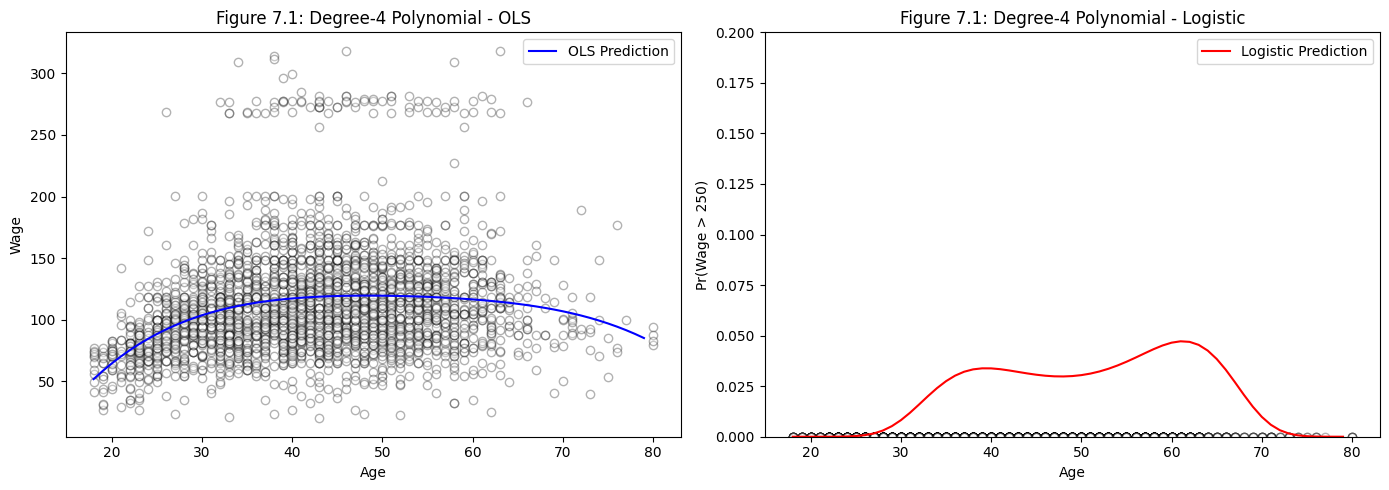

In [130]:
plot_predictions(X, y, x_grid, y_hat1, y01_hat1, 'Figure 7.1: Degree-4 Polynomial')

O **uso de funções polinomiais** das variáveis preditoras ***em um modelo linear impõe uma estrutura global à relação não linear*** entre $age$ e a variável resposta $wage$. Isso significa que **uma pequena mudança em uma parte do domínio pode afetar a forma da função em todo o intervalo**.

Como alternativa, podemos utilizar ***funções degrau (Step Functions)***, que evitam a imposição dessa estrutura global.

Por exemplo, podemos dividir o intervalo de age em faixas (ou "caixas") e estimar uma constante diferente para cada faixa. Isso nos permite capturar mudanças abruptas ou relações locais sem impor suavidade ou continuidade entre os intervalos.

### 2.2. Funções Degrau (*Step Functions*)

Construir uma função degrau significa, primeiro, escolher $ K $ pontos de corte $ c_1, c_2, \ldots, c_K $ no intervalo da variável $ \text{age} $, e então definir $ K + 1 $ variáveis indicadoras da seguinte forma:

$$
\begin{aligned}
C_0(\text{age}) &= \mathbb{I}(\text{age} < c_1) \\
C_1(\text{age}) &= \mathbb{I}(c_1 \leq \text{age} < c_2) \\
C_2(\text{age}) &= \mathbb{I}(c_2 \leq \text{age} < c_3) \\
&\vdots \\
C_{K-1}(\text{age}) &= \mathbb{I}(c_{K-1} \leq \text{age} < c_K) \\
C_K(\text{age}) &= \mathbb{I}(\text{age} \geq c_K)
\end{aligned}
$$

onde $ \mathbb{I}(\cdot) $ é a **função indicadora**, que assume valor 1 se a condição lógica for verdadeira, e 0 caso contrário.

Dessa forma, a função de regressão resultante estima **uma constante separada para cada faixa etária definida pelos cortes**, permitindo capturar variações locais sem impor continuidade ou suavidade entre os intervalos.


In [131]:
import pandas as pd
import statsmodels.api as sm

# 1. Criar a variável categórica com os cortes de age em 4 faixas
df["age_cut"] = pd.cut(df["age"], bins=4)

In [132]:
# 2. Criar dummies e garantir que são inteiros
dummies = pd.get_dummies(df["age_cut"], prefix="age_bin", drop_first=False).astype(int)
# 3. Juntar ao df
df = df.join(dummies)

In [133]:
df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,y01,age_cut,"age_bin_(17.938, 33.5]","age_bin_(33.5, 49.0]","age_bin_(49.0, 64.5]","age_bin_(64.5, 80.0]"
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,0,"(17.938, 33.5]",1,0,0,0
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,0,"(17.938, 33.5]",1,0,0,0
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,0,"(33.5, 49.0]",0,1,0,0
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,0,"(33.5, 49.0]",0,1,0,0
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154,0,"(49.0, 64.5]",0,0,1,0


***Regressão Stepwise***

In [134]:
# 4. Definir X com constante
X = df[dummies.columns]
# 5. Definir y
y = df["wage"]

# 6. Rodar regressão
model_step = sm.OLS(y, X, data=df).fit()
print(model_step.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.58
Date:                qua, 14 mai 2025   Prob (F-statistic):           1.13e-41
Time:                        17:10:19   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
age_bin_(17.938, 33.5]    94

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


A partir do resultado da regressão, podemos ver que os coeficientes de bin são significativos.


| Faixa Etária	| Coeficiente	| Interpretação
|--------------|----------------|----------------|
| (17.9, 33.5]	| 94.16	| Salário médio estimado para essa faixa: R$ 94,16
| (33.5, 49.0]	| 118.21	| Salário médio estimado para essa faixa: R$ 118,21
| (49.0, 64.5]	| 117.82	| Salário médio estimado para essa faixa: R$ 117,82
| (64.5, 80.0]	| 101.80	| Salário médio estimado para essa faixa: R$ 101,80



In [ ]:
# 1. Criar a grade de valores para idade
x_grid = np.linspace(df["age"].min(), df["age"].max(), 100)

# 2. Colocar os valores da grade nos mesmos bins da regressão
age_cut_grid = pd.cut(x_grid, bins=df["age_cut"].cat.categories)

# 3. Criar dummies com os mesmos nomes das colunas do modelo (sem drop_first!)
X_step_test = pd.get_dummies(age_cut_grid, prefix="age_bin")

# 4. Garantir que todas as colunas do modelo estejam presentes
for col in model_step.model.exog_names:  # usa colunas reais do modelo
    if col not in X_step_test.columns:
        X_step_test[col] = 0

# 5. Ordenar as colunas para bater com o modelo
X_step_test = X_step_test[model_step.model.exog_names]  # mesma ordem

# 6. Prever com o modelo (sem constante!)
y_hat2 = model_step.predict(X_step_test)

In [68]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(x_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5], dtype=int64)

In [72]:
# Get dummies, drop first dummy category, add constant
X_step_test = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_step_test = X_step_test.astype(float)
X_step_test.head()

,const,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [73]:
# Step prediction
X_step = X_step.astype(float)

y_hat2 = model_step.predict(X_step_test)

ValueError: shapes (100,5) and (4,) not aligned: 5 (dim 1) != 4 (dim 0)

**Regressão Logística em Etapas**

Vamos executar novamente uma regressão logística, já que nosso resultado é binário.


In [137]:
import statsmodels.api as sm

logit_step = sm.GLM(y01, X_step, family=sm.families.Binomial()).fit()
y01_hat2 = logit_step.predict(X_step_test)
logit_step.summary().tables[1]


,coef,std err,z,P>|z|,[0.025,0.975]
const,-5.6836,1.002,-5.674,0.000,-7.647,-3.720
"(25, 35]",1.2678,1.063,1.193,0.233,-0.816,3.351
"(35, 45]",2.3232,1.019,2.280,0.023,0.326,4.320
"(45, 65]",2.3685,1.015,2.335,0.020,0.380,4.357


**Plotagem**

Como é a função prevista?

ValueError: x and y must be the same size

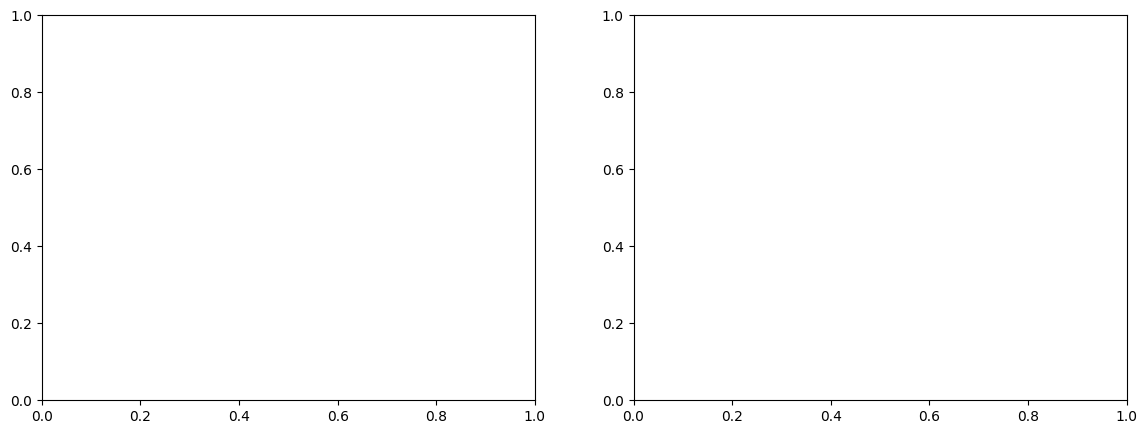

In [140]:
plot_predictions(X, y, x_grid, y_hat2, y01_hat2, 'Figure 7.2: Piecewise Constant')


In [141]:
def plot_predictions(age, y_real, x_grid, y_hat_ols, y_hat_logit, title):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico 1 - Regressão Linear (OLS)
    ax[0].scatter(age, y_real, color='w', edgecolor='k', alpha=0.3)
    ax[0].plot(x_grid, y_hat_ols, color='crimson', label='Função Degrau')
    ax[0].set_title(title + ' - Regressão Linear')
    ax[0].set_xlabel("Idade")
    ax[0].set_ylabel("Salário estimado")
    ax[0].grid(True)
    ax[0].legend()

    # Gráfico 2 - Regressão Logística (se for o caso)
    ax[1].plot(x_grid, y_hat_logit, color='blue', label='Logit Prediction')
    ax[1].set_title(title + ' - Regressão Logística')
    ax[1].set_xlabel("Idade")
    ax[1].set_ylabel("Probabilidade estimada")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


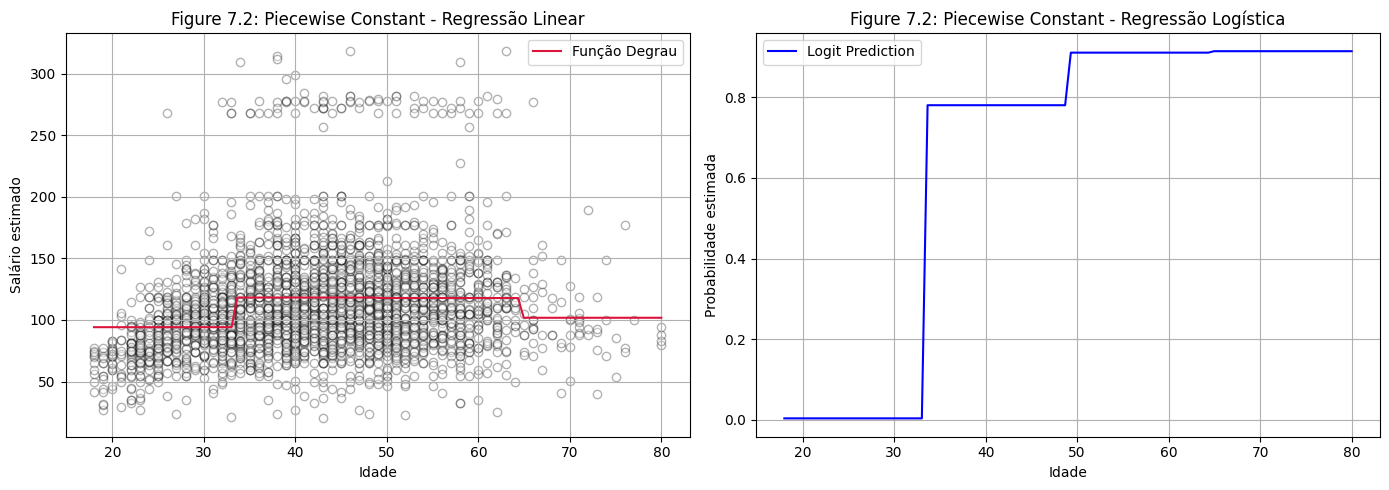

In [143]:
plot_predictions(df["age"], y, x_grid, y_hat2, y01_hat2, 'Figure 7.2: Piecewise Constant')


***Splines de regressão***


A regressão spline, ou regressão polinomial por partes, envolve o ajuste de polinômios de baixo grau separados em diferentes regiões de
. A ideia é ter uma especificação de regressão, mas com coeficientes diferentes em diferentes partes da
intervalo. Os pontos onde os coeficientes mudam são chamados de nós.

Por exemplo, poderíamos ter um polinômio de terceiro grau e dividir a amostra em dois.

$$ y_{i} = \beta_{01} + \beta_{11} x_{i} + \beta_{21} x_{i}^2 + \beta_{31} x_{i}^3 + \epsilon_{i} \quad \text{se } x_{i} < c $$

Agora temos dois conjuntos de coeficientes, um para cada subamostra.

Geralmente, usar mais nós resulta em um polinômio por partes mais flexível. Além disso, aumentar o grau do polinômio aumenta o grau de flexibilidade.

***Exemplo***

Agora vamos traçar 4 exemplos diferentes para o age wagerelacionamento:

Cúbico descontínuo por partes
Cúbico contínuo por partes
Quadrático (contínuo)
Linear contínuo por partes

In [144]:
# Cut dataset
df_short = df.iloc[:80,:]
X_short = df_short.age
y_short = df_short.wage
x_grid_short = np.arange(df_short.age.min(), df_short.age.max()+1).reshape(-1,1)

# 1. Discontinuous piecewise cubic
spline1 = "bs(x, knots=(50,50,50,50), degree=3, include_intercept=False)"

# 2. Continuous piecewise cubic
spline2 = "bs(x, knots=(50,50,50), degree=3, include_intercept=False)"

# 3. Quadratic (continuous)
spline3 = "bs(x, knots=(%s,%s), degree=2, include_intercept=False)" % (min(df.age), min(df.age))

# 4. Continuous piecewise linear
spline4 = "bs(x, knots=(%s,50), degree=1, include_intercept=False)" % min(df.age)

In [145]:
from patsy import dmatrix

# Generate spline predictions
def fit_predict_spline(spline, X, y, x_grid):
    transformed_x = dmatrix(spline, {"x": X}, return_type='dataframe')
    fit = sm.GLM(y, transformed_x).fit()
    y_hat = fit.predict(dmatrix(spline, {"x": x_grid}, return_type='dataframe'))
    return y_hat

y_hats = [fit_predict_spline(s, X_short, y_short, x_grid_short) for s in [spline1, spline2, spline3, spline4]]

In [146]:
import matplotlib.pyplot as plt

def plot_splines(df_short, x_grid, y_hats):
    titles = [
        'Discontinuous piecewise cubic spline',
        'Continuous piecewise cubic spline',
        'Quadratic spline (continuous)',
        'Continuous piecewise linear spline'
    ]
    
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    ax = ax.ravel()

    for i in range(4):
        ax[i].scatter(df_short.age, df_short.wage, color='w', edgecolor='k', alpha=0.4)
        ax[i].plot(x_grid, y_hats[i], color='crimson', lw=2)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Age")
        ax[i].set_ylabel("Wage")
    
    plt.tight_layout()
    plt.show()


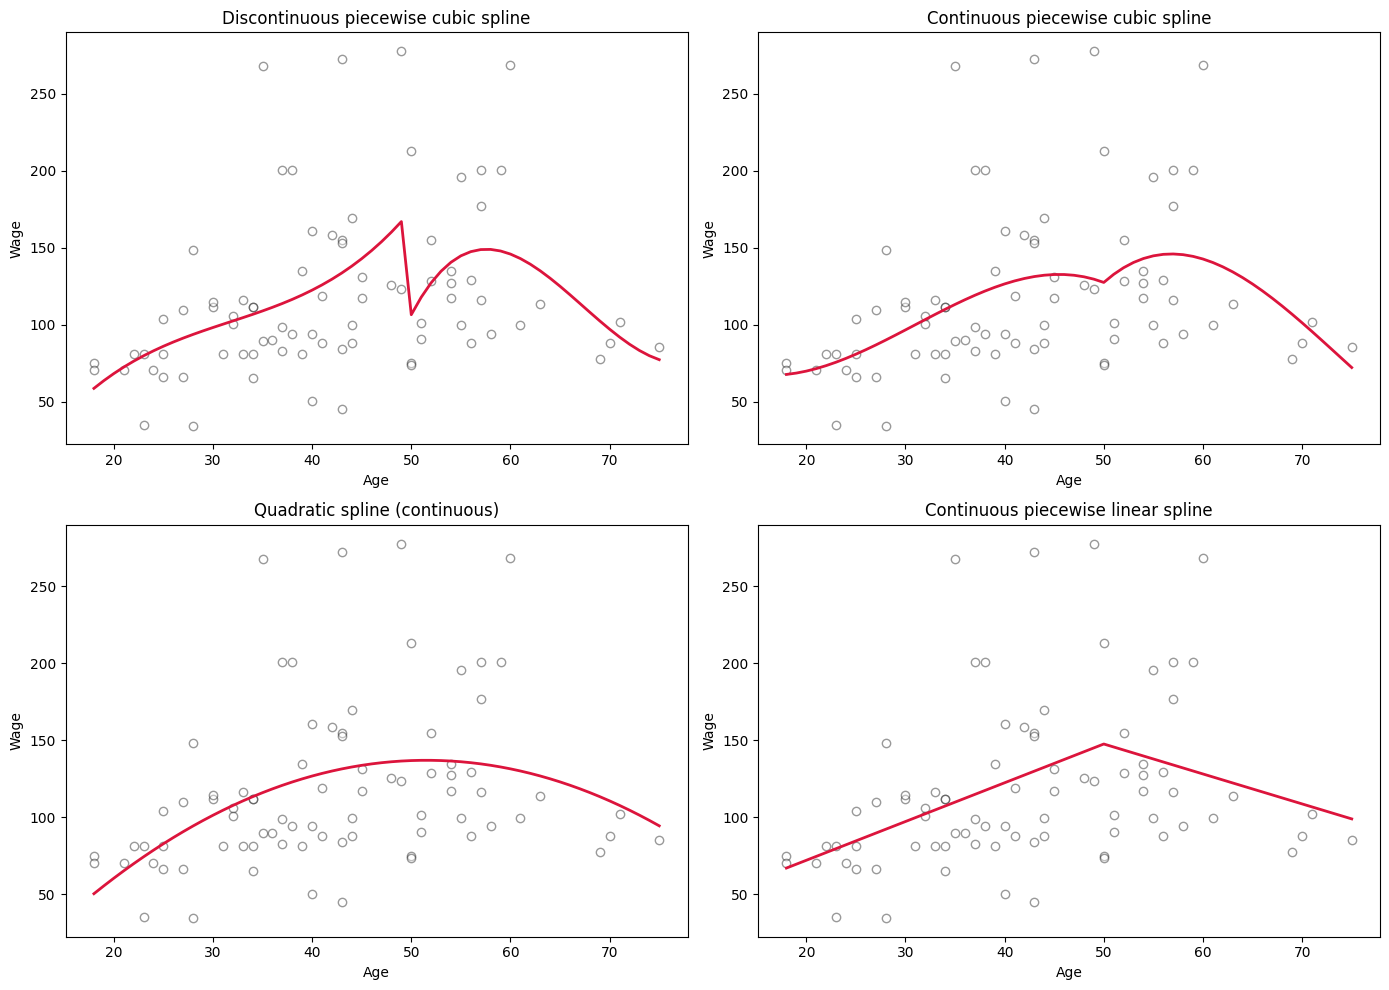

In [147]:
plot_splines(df_short, x_grid_short, y_hats)

***Comentário***

O primeiro exemplo nos faz pensar por que gostaríamos que nossa função fosse descontínua. A menos que esperemos um aumento salarial repentino em uma determinada idade, gostaríamos que a função fosse contínua. No entanto, se, por exemplo, dividirmos ageem torno da idade de aposentadoria, podemos esperar uma descontinuidade.

O segundo exemplo (canto superior direito) nos faz pensar por que desejaríamos que nossa função não fosse diferenciável. A menos que tenhamos algum mecanismo específico em mente, geralmente há um dilema entre tornar a função não diferenciável ou aumentar o grau do polinômio, como os dois últimos exemplos nos mostram. Obtemos um ajuste semelhante com um ajuste quadrático ou um ajuste linear descontínuo. A principal diferença é que, no segundo caso, estamos escolhendo o ponto de descontinuidade manualmente, em vez de deixar que os dados escolham como alterar a inclinação da curva.

***A representação da base Spline***

Como podemos ajustar um polinômio de grau d por partes sob a restrição de que ele (e possivelmente suas primeiras derivadas d − 1) seja contínuo?

A maneira mais direta de representar uma spline cúbica é começar com uma base para um polinômio cúbico — ou seja, x, x2, x3 — e, em seguida, adicionar uma função de base de potência truncada por nó. Uma função de base de potência truncada é definida como

$$ h(x, c)=(xc)_{+}^{3} = \Bigg{ (x-c)^{3}} \text{ se } x>c \text{ e } 0 \text{ caso contrário} $$


Pode-se mostrar que adicionar um termo da forma
ao modelo para um polinômio cúbico levará a uma descontinuidade apenas na terceira derivada em
; a função permanecerá contínua, com derivadas primeira e segunda contínuas, em cada um dos nós.

Splines Cúbicas
Uma maneira de especificar a spline é usando nós e graus de liberdade.

In [76]:
# Specifying 3 knots and 3 degrees of freedom
spline5 = "bs(x, knots=(25,40,60), degree=3, include_intercept=False)"
pred5 = fit_predict_spline(spline5, X, y, x_grid)

Sem nós
Quando ajustamos uma spline, onde devemos colocar os nós?

A spline de regressão é mais flexível em regiões com muitos nós, pois nessas regiões os coeficientes polinomiais podem mudar rapidamente. Portanto, uma opção é colocar mais nós onde acreditamos que a função pode variar mais rapidamente e menos nós onde ela parece mais estável. Embora essa opção possa funcionar bem, na prática é comum colocar os nós de maneira uniforme. Uma maneira de fazer isso é especificar os graus de liberdade desejados e, em seguida, fazer com que o software coloque automaticamente o número correspondente de nós em quantis uniformes dos dados.

In [77]:
# Specifying degree 3 and 6 degrees of freedom 
spline6 = "bs(x, df=6, degree=3, include_intercept=False)"
pred6 = fit_predict_spline(spline6, X, y, x_grid)

Splines naturais
Uma spline natural é uma spline de regressão com restrições de contorno adicionais: a função precisa ser linear no contorno (na região onde X é menor que o menor nó ou maior que o maior nó). Essa restrição adicional significa que as splines naturais geralmente produzem estimativas mais estáveis ​​nos contornos.

In [78]:
# Natural spline with 4 degrees of freedom
spline7 = "cr(x, df=4)"
pred7 = fit_predict_spline(spline7, X, y, x_grid)

Comparação

In [79]:
# Compare predictons
preds = [pred5, pred6, pred7]
labels = ['degree 3, knots 3', 'degree 3, degrees of freedom 3', 'natural, degrees of freedom 4']
compare_predictions(X, y, x_grid, preds, labels)

NameError: name 'compare_predictions' is not defined

Comparação com Regressão Polinomial
Splines de regressão geralmente apresentam resultados superiores à regressão polinomial. Isso ocorre porque, diferentemente dos polinômios, que precisam usar um grau alto para produzir ajustes flexíveis, as splines introduzem flexibilidade aumentando o número de nós, mas mantendo o grau fixo.

Agora estamos ajustando um polinômio de grau 15 e uma spline com 15 graus de liberdade.

# Polynomial of degree 15

In [80]:
# Polynomial of degree 15
X_poly15 = PolynomialFeatures(15).fit_transform(df.age.values.reshape(-1,1))
ols_poly_15 = sm.OLS(y, X_poly15).fit()
pred8 = ols_poly_15.predict(PolynomialFeatures(15).fit_transform(x_grid))

# Spline with 15 degrees of freedon
spline9 = "bs(x, df=15, degree=3, include_intercept=False)"
pred9 = fit_predict_spline(spline9, X, y, x_grid)

In [81]:
# Compare predictons
preds = [pred8, pred9]
labels = ['Polynomial', 'Spline']
compare_predictions(X, y, x_grid, preds, labels)

NameError: name 'compare_predictions' is not defined

Como podemos ver, apesar das duas regressões terem os mesmos graus de liberdade, o ajuste polinomial é muito mais volátil. Podemos compará-los em algumas dimensões.

Regressão Local
Até agora, examinamos os chamados " métodos globais ": métodos que tentam aplicar uma especificação de função única a todos os dados. A especificação da função pode ser complexa, como no caso de splines, mas pode ser expressa globalmente.

A regressão local é uma abordagem diferente para ajustar funções não lineares flexíveis, que envolve calcular o ajuste em um ponto alvo
usando apenas as observações de treinamento próximas.

Detalhes
Como funciona a regressão local?

Ingredientes:
,
.

Como você produz uma previsão
em um novo ponto
?

Tome uma série de pontos em
perto de
:
Atribua um peso a cada um desses pontos
Ajuste uma regressão ponderada de mínimos quadrados de
sobre
Use os coeficientes estimados
prever


Gerar Dados

In [82]:
# Set seed
np.random.seed(1)

# Generate data
X_sim = np.sort(np.random.uniform(0,1,100))
e = np.random.uniform(-.5,.5,100)
y_sim = -4*X_sim**2 + 3*X_sim + e

# True Generating process without noise
X_grid = np.linspace(0,1,100)
y_grid = -4*X_grid**2 + 3*X_grid

Plotagem
Vamos visualizar os dados simulados e a curva sem ruído.

In [83]:
plot_simulated_data(X_sim, y_sim, X_grid, y_grid);

NameError: name 'plot_simulated_data' is not defined

Ajuste de regressão LL
Agora ajustamos uma regressão linear local.

In [ ]:
# Settings
spec = 'll'
bandwidth = 0.1
kernel = 'gaussian'

# Locally linear regression
local_reg = KernelReg(y_sim, X_sim.reshape(-1,1), 
                      var_type='c', 
                      reg_type=spec, 
                      bw=[bandwidth])
y_hat = KernelReg.fit(local_reg)

O que os parâmetros significam?

var_type: tipo de variável dependente ( cou seja, contínua )
reg_type: especificação de regressão local ( llou seja, localmente linear )
bw : comprimento de largura de banda ( 0,1 )
ckertype: tipo de kernel ( gaussiano )

**Previsão**

Como é a previsão?



In [84]:
fig, ax = plot_simulated_data(X_sim, y_sim, X_grid, y_grid);
make_figure_7_9a(fig, ax, X_sim, y_hat);

NameError: name 'plot_simulated_data' is not defined

Detalhes
Como exatamente a previsão foi gerada? Ela foi gerada pontualmente. Agora, vamos analisar a previsão em um ponto específico:
.

Procedemos da seguinte forma:

Selecionamos o ponto focal:
Selecionamos observações próximas a
, ou seja
e
Aplicamos pesos gaussianos
Executamos uma regressão linear ponderada de
sobre

In [ ]:
# Get local X and y
x_i = 0.5
close_to_i = (x_i-bandwidth < X_sim) & (X_sim < x_i+bandwidth)
X_tilde = X_sim[close_to_i]
y_tilde = y_sim[close_to_i]

# Get local estimates
local_estimate = KernelReg.fit(local_reg, data_predict=[x_i])
y_i_hat = local_estimate[0]
beta_i_hat = local_estimate[1]
alpha_i_hat = y_i_hat - beta_i_hat*x_i
print('Estimates: alpha=%1.4f, beta=%1.4f' % (alpha_i_hat, beta_i_hat))

Visualização
Agora podemos usar os coeficientes estimados localmente para prever o valor de
para
.

In [ ]:
# Build local predictions
close_to_i_grid = (x_i-bandwidth < X_grid) & (X_grid < x_i+bandwidth)
X_grid_tilde = X_grid[close_to_i_grid].reshape(-1,1)
y_grid_tilde = alpha_i_hat + X_grid_tilde*beta_i_hat

In [ ]:
fig, ax = plot_simulated_data(X_sim, y_sim, X_grid, y_grid);
make_figure_7_9a(fig, ax, X_sim, y_hat);
make_figure_7_9b(fig, ax, X_tilde, y_tilde, X_grid_tilde, y_grid_tilde, x_i, y_i_hat)

Ampliando
Podemos ampliar e olhar apenas para a amostra “ próximo a i ”.

In [ ]:
sns.regplot(X_tilde, y_tilde);

Por que a reta é inclinada para cima? Esquecemos os pesos gaussianos.

In [ ]:
# Weights
w = norm.pdf((X_sim-x_i)/bandwidth)

# Estimate LWS
mod_wls = sm.WLS(y_sim, sm.add_constant(X_sim), weights=w)
results = mod_wls.fit()

print('Estimates: alpha=%1.4f, beta=%1.4f' % tuple(results.params))

De fato, obtivemos as mesmas estimativas de antes. Observe duas coisas:

a largura ruim define o parâmetro de escala dos pesos gaussianos
nossa regressão linear local é igualmente global

In [ ]:
make_figure_7_9d(X_sim, y_sim, w, results, X_grid, x_i, y_i_hat)

Modelos Aditivos Generalizados

Modelos aditivos generalizados (GAMs) fornecem uma estrutura geral para estender um modelo linear padrão, permitindo funções não lineares de cada uma das variáveis, mantendo a aditividade.

GAM para problemas de regressão
Imagine estender a estrutura geral de regressão a algum modelo aditivo separavelmente da forma


É chamado de modelo aditivo porque calculamos um modelo separado
para cada
, e então some todas as suas contribuições.

Considere por exemplo o seguinte modelo


Exemplo
Usaremos as seguintes funções:

: spline natural com 8 graus de liberdade
: spline natural com 10 graus de liberdade
: função degrau



In [ ]:
# Set X and y
df['education_'] = LabelEncoder().fit_transform(df["education"])
X = df[['year','age','education_']].to_numpy()
y = df[['wage']].to_numpy()

## model
linear_gam = LinearGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2))
linear_gam.gridsearch(X, y);

Plotagem

In [ ]:
plot_gam(linear_gam)

Prós e contras
Antes de prosseguirmos, vamos resumir as vantagens de um GAM.

Os GAMs nos permitem ajustar uma estrutura não linear
para cada um
, para que possamos modelar automaticamente relacionamentos não lineares que a regressão linear padrão não irá alcançar
Os ajustes não lineares podem potencialmente fazer previsões mais precisas
Como o modelo é aditivo, ainda podemos examinar o efeito de cada
sobre
separadamente
A suavidade da função
para a variável
pode ser resumido por meio de graus de liberdade.
A principal limitação dos GAMs é que o modelo é restrito a ser aditivo. Com muitas variáveis, interações importantes podem ser perdidas. No entanto, assim como na regressão linear, podemos adicionar manualmente termos de interação ao modelo GAM, incluindo preditores adicionais da forma
.

GAMs para problemas de classificação

Podemos usar GAMs também com uma variável dependente binária.



In [ ]:
# Binary dependent variable
y_binary = (y>250)

## Logit link function
logit_gam = LogisticGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2), fit_intercept=True)
logit_gam.gridsearch(X, y_binary);

In [ ]:
plot_gam(logit_gam)

Os resultados são qualitativamente semelhantes ao caso não binário.